# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos UCB en un problema de k-armed bandit, usando bandidos de tipo Bernouilli, binomial y normal.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Authors: Jesús Verdú Chacón
             Jorge López Abad
    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/ldaniel-hm/eml_k_bandit.git
!cd eml_k_bandit/

Cloning into 'eml_k_bandit'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 66 (delta 28), reused 42 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 318.16 KiB | 2.89 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/eml_k_bandit')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List
import matplotlib.pyplot as plt

from typing import List, Dict
from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, Bandit
from plotting import plot_average_rewards, plot_optimal_selections


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/eml_k_bandit']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.
    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_stats = [{'mean_rewards': np.zeros(bandit.k), 'selections': np.zeros(bandit.k)} for _ in algorithms]

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.
    optimal_reward = bandit.pull_arm(optimal_arm)

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                arm_stats[idx]['mean_rewards'][chosen_arm] += reward # Actualizar la ganancia del brazo seleccionado por el algoritmo.
                arm_stats[idx]['selections'][chosen_arm] += 1 # Actualizar número selecciones del brazo seleccionado
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                regret_accumulated[idx, step] = step*optimal_reward - total_rewards_per_algo[idx]

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100
    regret_accumulated /= runs
    for stat in arm_stats:
        stat['mean_rewards'] /= runs
        stat['selections'] /= runs

    return rewards, optimal_selections, regret_accumulated, arm_stats


## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos UCB con bandidos de tipo bernoulli, binomial y normal.

In [ ]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


In [ ]:
sum(arm_stats[0]['selections'])

1000.0

## Definimos las funciones para dibujar

In [ ]:
def plot_optimal_selections(steps: int, optimal_selections: np.ndarray, algorithms: List[Algorithm]):
    """
    Genera la gráfica de Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo.

    :param steps: Número de pasos de tiempo.
    :param optimal_selections: Matriz de porcentaje de selecciones óptimas.
    :param algorithms: Lista de instancias de algoritmos comparados.
    """

    plt.figure(figsize=(10, 6))

    for idx, algo in enumerate(algorithms):
        plt.plot(range(steps), optimal_selections[idx], label=f"{algo.__class__.__name__} (ε={algo.epsilon})")

    plt.xlabel("Pasos de tiempo")
    plt.ylabel("Porcentaje de selecciones óptimas (%)")
    plt.title("Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo")
    plt.legend()
    plt.grid()
    plt.show()



In [ ]:
def plot_arm_statistics(arm_stats: List[Dict],
algorithms: List[Algorithm], k: int, optimal_arm: int, *args):
    """
    Genera gráficas separadas de Selección de Arms:
    Ganancia obtenida por cada brazo por algoritmo.

    :param arm_stats: Lista (de diccionarios) con estadísticas de cada brazo por algoritmo.
    :param algorithms: Lista de instancias de algoritmos comparados.
    :param k: Número de brazos.
    :param args: Opcional. Parámetros que consideres
    """

    num_algorithms = len(algorithms)

    plt.figure(figsize=(10, 6))
    width = 0.2

    for idx, algo in enumerate(algorithms):
        plt.figure(figsize=(10, 6))
        label = f"{algo.__class__.__name__} (ε={algo.epsilon})"
        mean_rewards = arm_stats[idx]['mean_rewards']
        selections = arm_stats[idx]['selections']

        x_positions = np.arange(1, k+1)
        x_labels = [f"{i}\n({int(selections[i-1])} veces)" for i in range(1, k+1)]

        colors = ['green' if (i-1) == optimal_arm else 'blue' for i in x_positions]

        plt.bar(x_positions, mean_rewards, color=colors, alpha=0.7, edgecolor='black')

        plt.xlabel("Brazos del bandido (Número de selecciones entre paréntesis)")
        plt.ylabel("Ganancia promedio")
        plt.title(f"Ganancia promedio por brazo - {label}")
        plt.xticks(x_positions, x_labels, rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

In [ ]:
def plot_regret(steps: int,
regret_accumulated: np.ndarray,
algorithms: List[Algorithm], *args):
    """
    Genera la gráfica de Regret Acumulado vs Pasos de Tiempo
    :param steps: Número de pasos de tiempo.
    :param regret_accumulated: Matriz de regret acumulado (algoritmos x pasos).
    :param algorithms: Lista de instancias de algoritmos comparados.
    :param args: Opcional. Parámetros que consideres. P.e. la cota teórica Cte * ln(T).
    """

    plt.figure(figsize=(10, 6))

    for idx, algo in enumerate(algorithms):
        plt.plot(range(steps), regret_accumulated[idx], label=f"{algo.__class__.__name__} (ε={algo.epsilon})")

    plt.xlabel("Pasos de tiempo")
    plt.ylabel("Arrepentimiento acumulado")
    plt.title("Arrepentimiento acumulado vs Pasos de Tiempo")
    plt.legend()
    plt.grid()
    plt.show()

## Visualización de los resultados

### Recompensa promedio vs pasos de tiempo

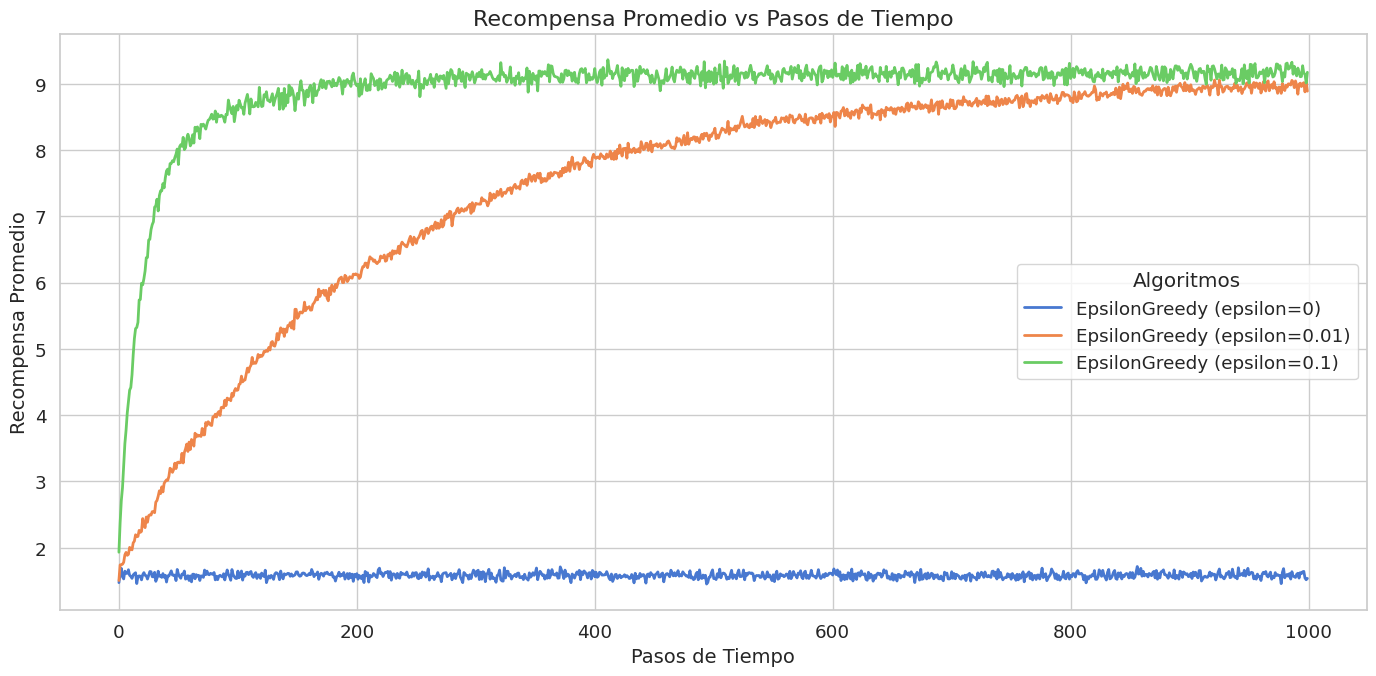

In [ ]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **En las tres gráficas de esta sección, las tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





### Porcentaje de selección del brazo óptimo vs pasos de tiempo

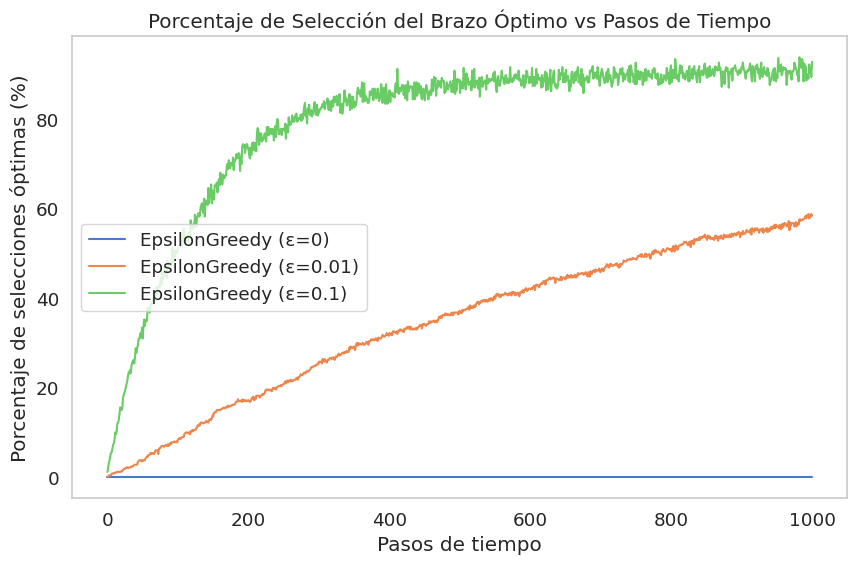

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo"**. Al igual que en la imagen anterior y en las venideras, en la gráfica se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestran es este caso el porcentaje promedio de selección del brazo óptimo la **recompensa promedio** obtenida por cada algoritmo.

* **Crecimiento del porcentaje de selección del brazo óptimo:**
   - La línea **verde (ε=0.1)** alcanza rápidamente -a los doscientos pasos de tiempo- un porcentaje promedio de selección del brazo óptimo del 80% y se estabiliza entre el 80% y el 90%. Esto indica que la estrategia con mayor exploración aprende rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1. Este crecimiento permanece lineal en el tiempo, llegando solamente a un 60% al alcanzar los mil pasos de tiempo.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





### Arrepentimiento acumulado vs pasos de tiempo

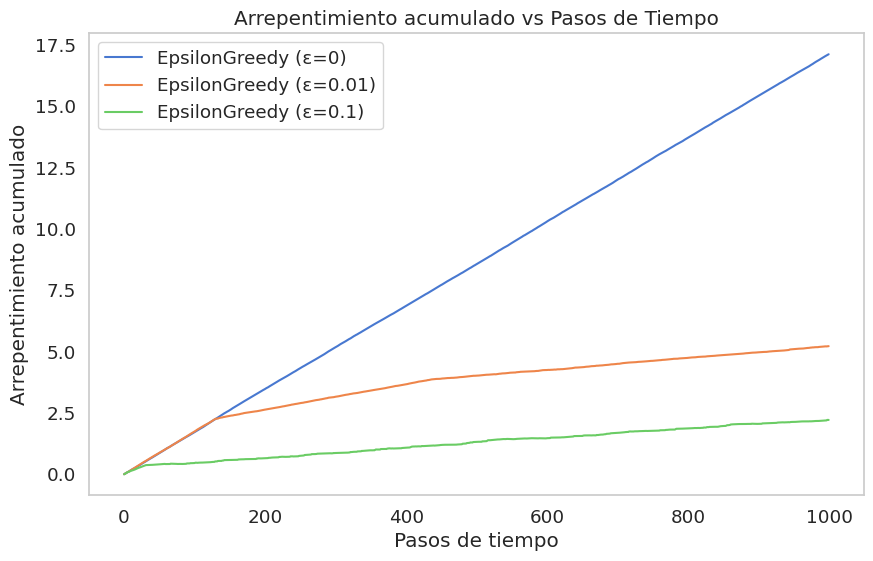

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Arrepentimiento acumulado vs Pasos de Tiempo"**. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el arrepentimiento acumulado de cada algoritmo.

* **Crecimiento del arrepentimiento acumulado:**
   - La línea **verde (ε=0.1)** muestra un crecimiento leve pero constante en el tiempo, teniendo los valores más bajos entre los tres algoritmos. Esto muestra que la estrategia con mayor exploración es la que más veces logra elegir al brazo óptimo, lo cual se muestra en sintonía con la gráfica anterior.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento similar al de la línea azul hasta casi alcanzar los doscientos pasos, momento a partir del cual presente un crecimiento análogo al de la estrategias más exploradora.
   - La línea **azul (ε=0)** es la que mayor crecimiento muestra de las tres lo cual sugiere que es la que menos veces logra elegir al brazo óptimo.

---





### Porcentaje de selección del brazo óptimo vs pasos de tiempo

<Figure size 1000x600 with 0 Axes>

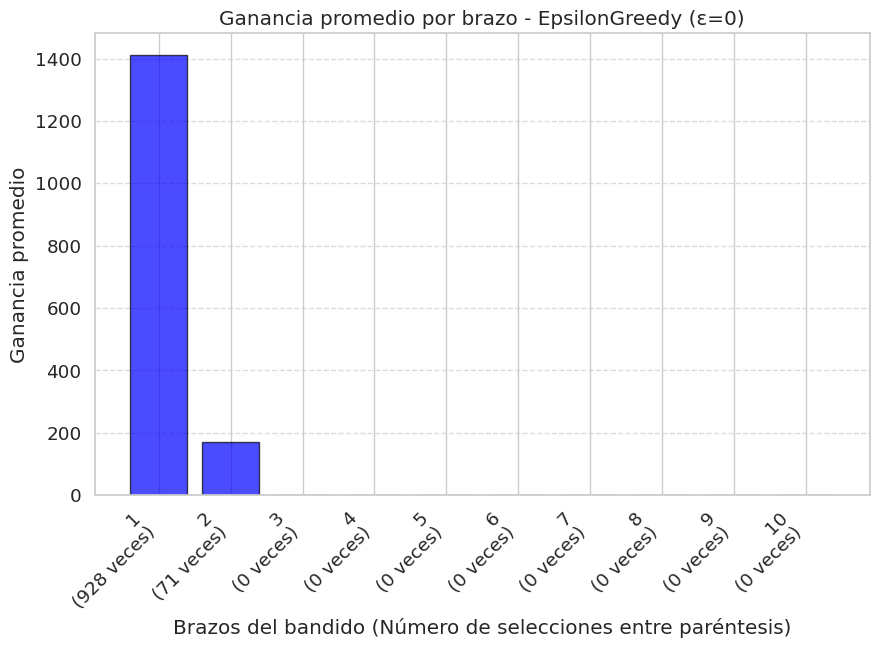

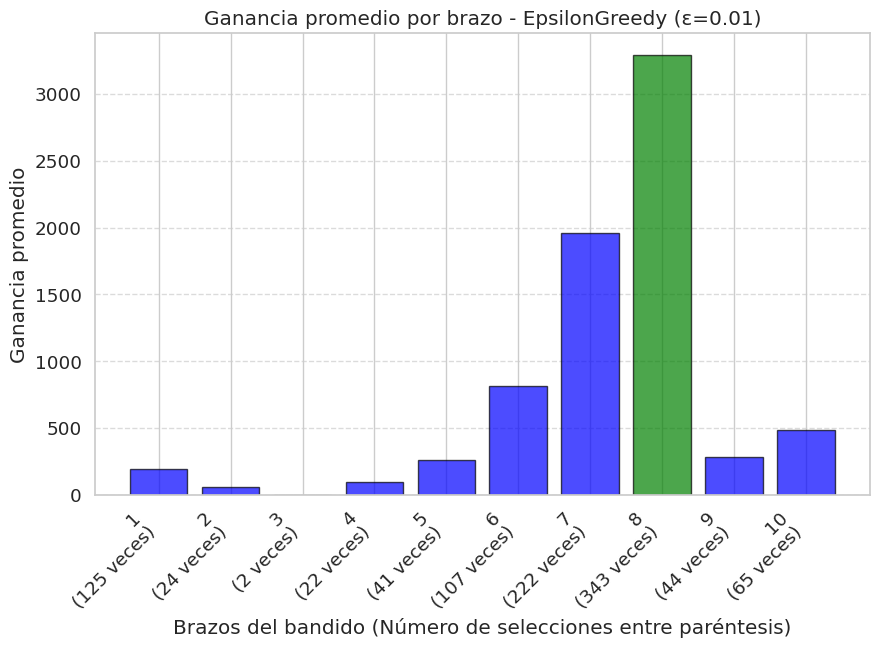

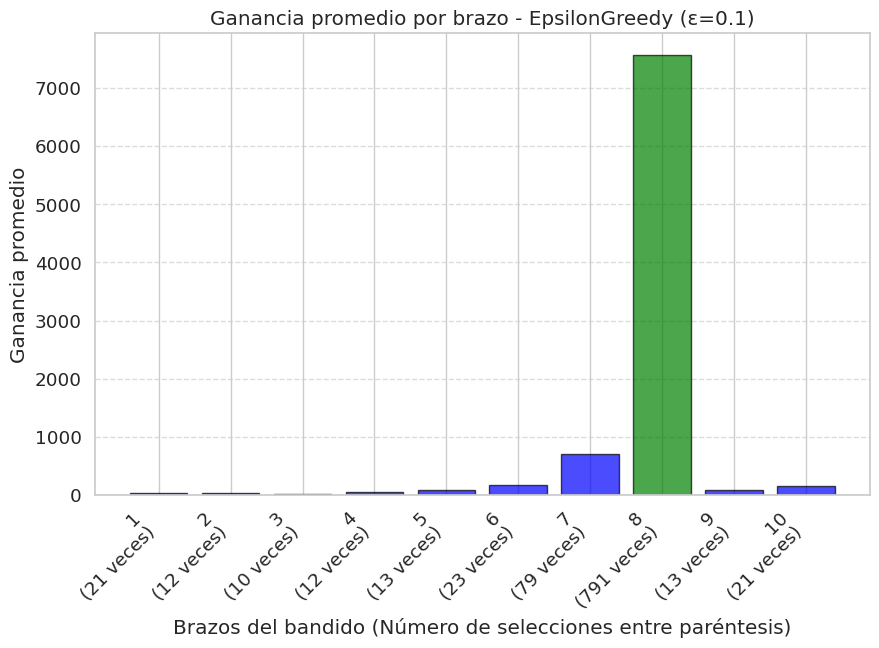

In [ ]:
plot_arm_statistics(arm_stats, algorithms, k, optimal_arm)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra tres gráficos de barras, cada uno titulado **"Ganancia promedio por brazo"**. En el eje **x** se representan los **brazos del bandido**, indicando en paréntesis el número de selecciones por brazo; mientras que en el eje **y** se muestra la ganancia obtenida de cada brazo. Además, la barra del brazo óptimo se muestra en verde y la del resto de brazos en azul.

1. **Las tres gráficas que se muestran se corresponden a diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Primera gráfica (ε=0):** Representa los resultados de la estrategia completamente **explotadora**.
   - **Segunda gráfica (ε=0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Tercera gráfica (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Ganancia y número de selecciones promedio por brazo:**
   - La **primera gráfica (ε=0)** se corresponde con la estrategia más explotadora. En ella podemos ver que solamente se seleccionan los brazos uno y dos.
   - La **segunda gráfica (ε=0.1)** muestra que el algoritmo es capaz de seleccionar mayoritariamente el brazo óptimo, aunque yerra en numerosas ocasiones, dando lugar a que otros brazos sean elegidos un número de veces similar aunque menor.
   - La **tercera gráfica (ε=0.01)** muestra que se consigue seleccionar el brazo óptimo en la amplia mayoría de las ocasiones. Asimismo, la ganancia obtenida en este caso es notablemente superior a la obtenida con los otros valores de ε.

---





## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

Los gráficos de línea y de barras confirman este comportamiento:
- **ε=0.1 (verde en los gráficos de línea y el último en los de barras)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo, dando lugar esto último a que también sea el que obtenga el menor arrepentimiento promedio y la mayor ganancia y selecciones del brazo óptimo.
- **ε=0.01 (naranja en los gráficos de línea y el segundo en los de barras)** explora menos, por lo que tarda más en converger a una recompensa alta. El arrepentimiento promedio es algo mayor que en el caso anterior y el número de selecciones del brazo óptimo, aunque mayoritario respecto del resto de brazos, claramente inferior al obtenido para el primer caso.
- **ε=0 (azul en los gráficos de línea y el primero en los de barras)** no explora en absoluto y queda atrapado en una recompensa subóptima. Además, el arrepentimiento promedio es alto y en ningún momento logra seleccionar el brazo óptimo debido a la mentada falta de exploración.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión, **los gráficos muestran cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀